In [13]:
import numpy as np
import pandas as pd

from scipy import stats as sts

import matplotlib.pyplot as plt
import warnings 

plt.style.use('ggplot')
%matplotlib inline
warnings.filterwarnings('ignore')

import pymc3 as pm
import arviz as az
import theano.tensor as tt
pm.__version__

'3.9.3'

# Упражнение 1 (Маша и медведи)

Помните задачку с вынюхиванием из лекции? Давайте начнём с того, что попробуем решить её в `pymc3`.

__Модель медведя:__ $y_i \sim N(m, 2^2)$

__Априорное мнение, где спряталась Маша:__ $m \sim N(1, 4^2)$

In [3]:
y = np.array([0.5, -1]) # медведи

Задайте априорное распределение и нашу модель.

In [5]:
basic_model = pm.Model()

with basic_model:
    m = pm.Normal('m', mu=1, sigma=4)
    y_obs = pm.Normal('b',mu = m, sigma=2, observed = y)

Найдите моду апостериорного распределения (байесовские методы для бедных). Запишите результат в переменную `map_estimate`.

In [6]:
map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'m': array(-0.11111111)}

Обучите модельс с помощью MCMC, 500 итераций для обучения будет достаточно. 

In [7]:
with basic_model:
    trace = pm.sample(500, return_inferencedata=False, model=basic_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 23 seconds.


Посмотрите на визуализацию Марковских цепей. Правда ли, что цепь сошлась?

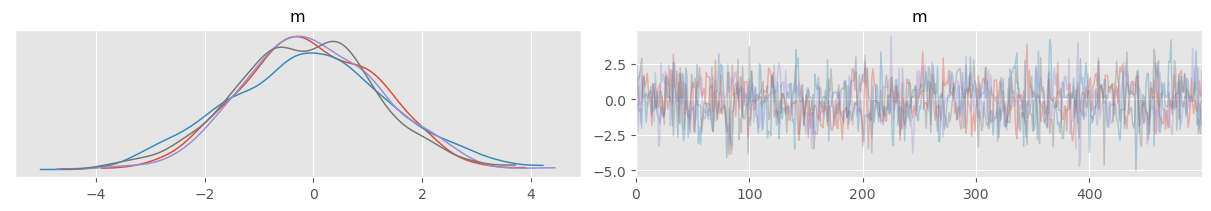

In [9]:
az.plot_trace(trace);

Найдите вероятность $P(m < 0)$. Ответ запишите в переменную `ans_prob`.

In [10]:
ans_prob = np.mean(trace['m']<0)
print(ans_prob)

0.535


# Упражнение 2 (Челленджер)

Байесовский подход - это просто другой способ оценивать те же самые модели. Например, давайте попробуем оценить логистическую регрессию. 

$28$ января $1986$ года космический шатл «Челленджер» взорвался при взлёте. Семь астронавтов, находившихся на борту, погибли. В ходе расследования причин катастрофы основной версией была неполадка с резиновыми уплотнительными кольцами в соединении с ракетными ускорителями. Для $23$ предшествовавших катастрофе полётов «Челленджера» известны температура воздуха и появление повреждений хотя бы у одного из уплотнительных колец.

In [11]:
df = pd.read_csv('challenger.csv', sep=',')
print(df.shape)
df.head()

(23, 3)


,Date,Temperature,Incident
0,04/12/1981,66,0
1,11/12/1981,70,1
2,3/22/82,69,0
3,01/11/1982,68,0
4,04/04/1983,67,0


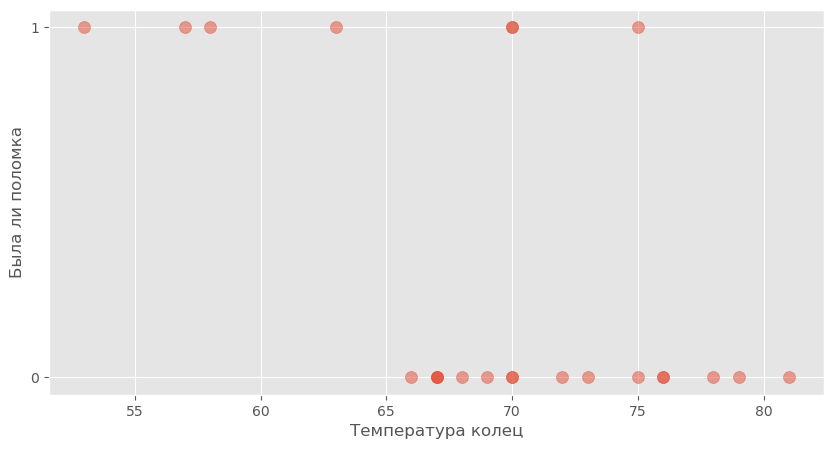

In [12]:
t = df.Temperature.values
y = df.Incident.values

plt.figure(figsize=(10, 5))
plt.scatter(t, y, s=75, alpha=0.5)
plt.yticks([0, 1])

plt.ylabel("Была ли поломка")
plt.xlabel("Температура колец");


Обучим Байесовскую версию логистичесской регресcии.  Модель буде выглядеть следующим образом: 

\begin{equation*}
\begin{aligned}
& \beta \sim N(0, 10^2) \\
& \alpha \sim N(0, 10^2) \\
& p \sim Bern(p) \\
& p = P(y = 1) = \frac{1}{1 + e^{\alpha + \beta \cdot t}}
\end{aligned}
\end{equation*}

In [15]:
t = df.Temperature.values
y = df.Incident.values

with pm.Model() as model:
    
    beta = pm.Normal("beta", mu=0, sigma=10)
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*t + alpha)))
    y_obs = pm.Bernoulli('y_obs', p, observed=y)

In [16]:
map_estimate = pm.find_MAP(model=model)

In [17]:
map_estimate

{'beta': array(0.16651426),
 'alpha': array(-10.55271034),
 'p': array([0.39240099, 0.24912435, 0.28155251, 0.316423  , 0.35348733,
        0.19211642, 0.16758636, 0.24912435, 0.74295751, 0.51557294,
        0.24912435, 0.08051265, 0.35348733, 0.84908654, 0.35348733,
        0.12610347, 0.24912435, 0.05045291, 0.10886635, 0.06901519,
        0.12610347, 0.10886635, 0.70989687])}

In [18]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=map_estimate)
    burned_trace = trace[100000::10]

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]


Sampling 4 chains for 1_000 tune and 120_000 draw iterations (4_000 + 480_000 draws total) took 52 seconds.
The number of effective samples is smaller than 10% for some parameters.


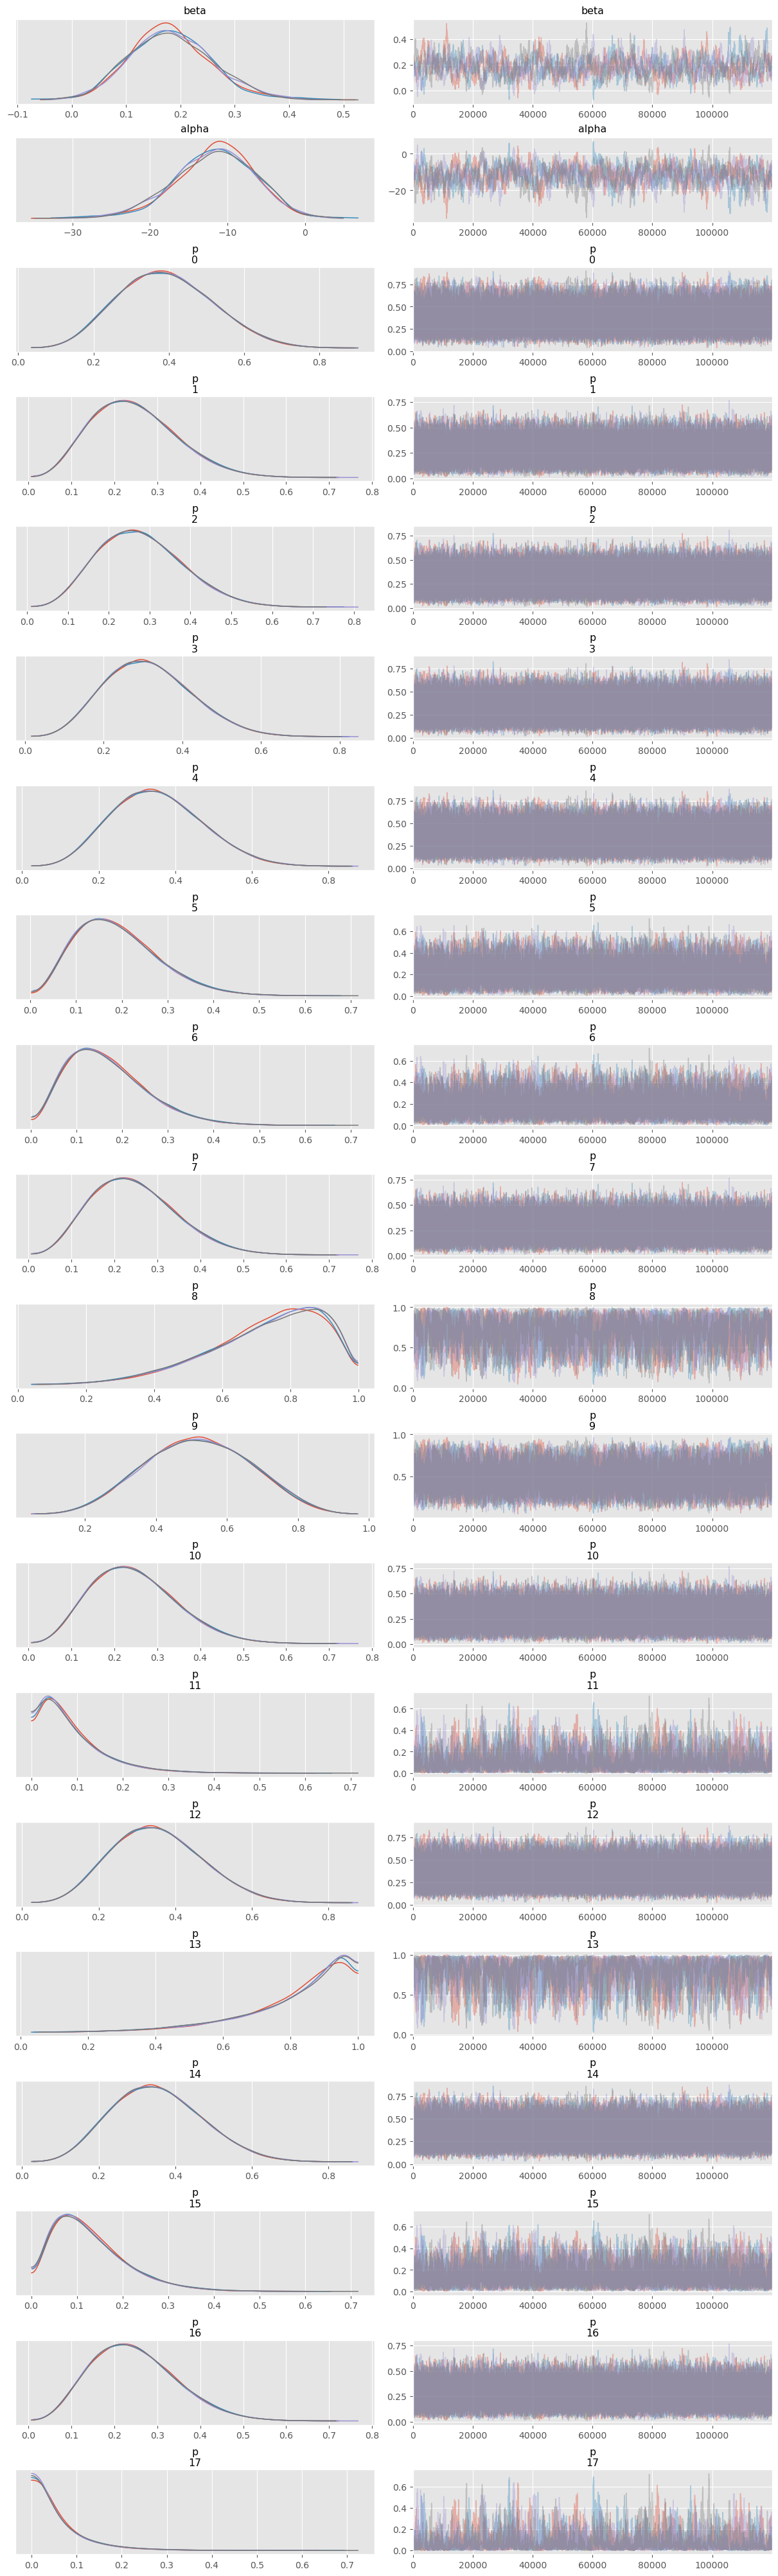

In [19]:
import arviz as az
az.plot_trace(trace);

In [20]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta,0.183,0.076,0.045,0.329,0.004,0.003,381.0,381.0,380.0,864.0,1.0
alpha,-11.613,5.164,-21.650,-2.340,0.264,0.187,382.0,382.0,381.0,875.0,1.0
p[0],0.394,0.124,0.168,0.625,0.002,0.001,5659.0,5113.0,5964.0,14213.0,1.0
p[1],0.247,0.098,0.073,0.428,0.001,0.001,7159.0,7159.0,6383.0,16028.0,1.0
p[2],0.280,0.103,0.097,0.473,0.001,0.000,39943.0,39943.0,31378.0,42611.0,1.0
p[3],0.315,0.109,0.118,0.519,0.000,0.000,157724.0,157724.0,156899.0,155661.0,1.0
p[4],0.354,0.116,0.146,0.574,0.001,0.001,25558.0,19988.0,29255.0,39551.0,1.0
p[5],0.191,0.090,0.040,0.357,0.002,0.001,1849.0,1849.0,1726.0,5886.0,1.0
p[6],0.168,0.086,0.025,0.325,0.002,0.002,1317.0,1317.0,1231.0,4306.0,1.0
p[7],0.247,0.098,0.073,0.428,0.001,0.001,7159.0,7159.0,6383.0,16028.0,1.0


Какова вероятность того, что $\beta < 0.0001$? То есть, какова вероятность того, что между температурой и вероятностью поломки нет связи? Запишите овтет в переменную `prob_beta`.

In [22]:
prob_beta = np.mean(trace['beta'] < 0.0001)
print(prob_beta)

0.004933333333333333


Нарисуем Получившиеся результаты. Для каждой температуры найдем $95\%$ байесовский интервал для вероятности того, что катастрофа произойдёт.

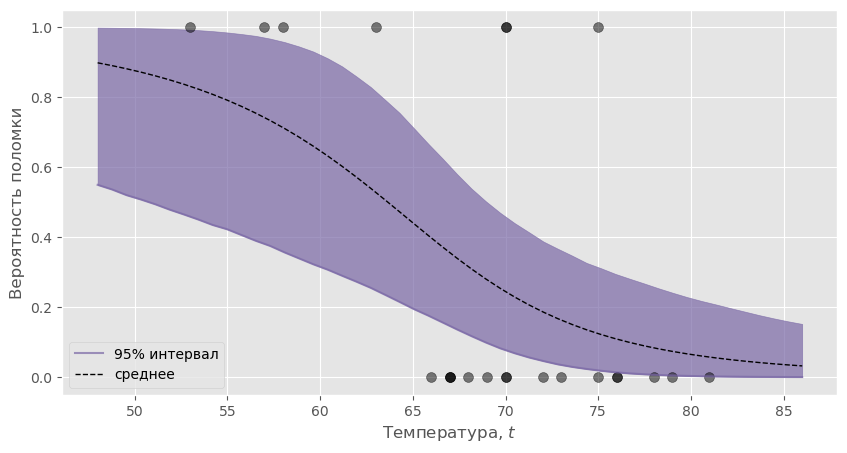

In [24]:
from scipy.stats.mstats import mquantiles

def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

t_seq = np.linspace(t.min() - 5, t.max()+5, 50)[:, None]
p_seq = logistic(t_seq.T, burned_trace['beta'][:,None], burned_trace['alpha'][:,None])

mean_prob_t = p_seq.mean(axis=0)
qs = mquantiles(p_seq, [0.025, 0.975], axis=0)

plt.figure(figsize=(10,5))
plt.fill_between(t_seq[:, 0], *qs, alpha=0.7, color="#7A68A6")
plt.plot(t_seq[:, 0], qs[0], label="95% интервал", color="#7A68A6", alpha=0.7)
plt.plot(t_seq, mean_prob_t, lw=1, ls="--", color="k", label="среднее")
plt.legend(loc="lower left")
plt.scatter(t, y, color="k", s=50, alpha=0.5)

plt.xlabel("Температура, $t$")
plt.ylabel("Вероятность поломки");

В день катастрофы температура уплотнителя была $31$ градус по Фарингейту. Найдите апостерионое распределение  вероятности катастрофы. 

In [26]:
prob_31 = logistic(31, burned_trace['beta'][:,None], burned_trace['alpha'][:,None])

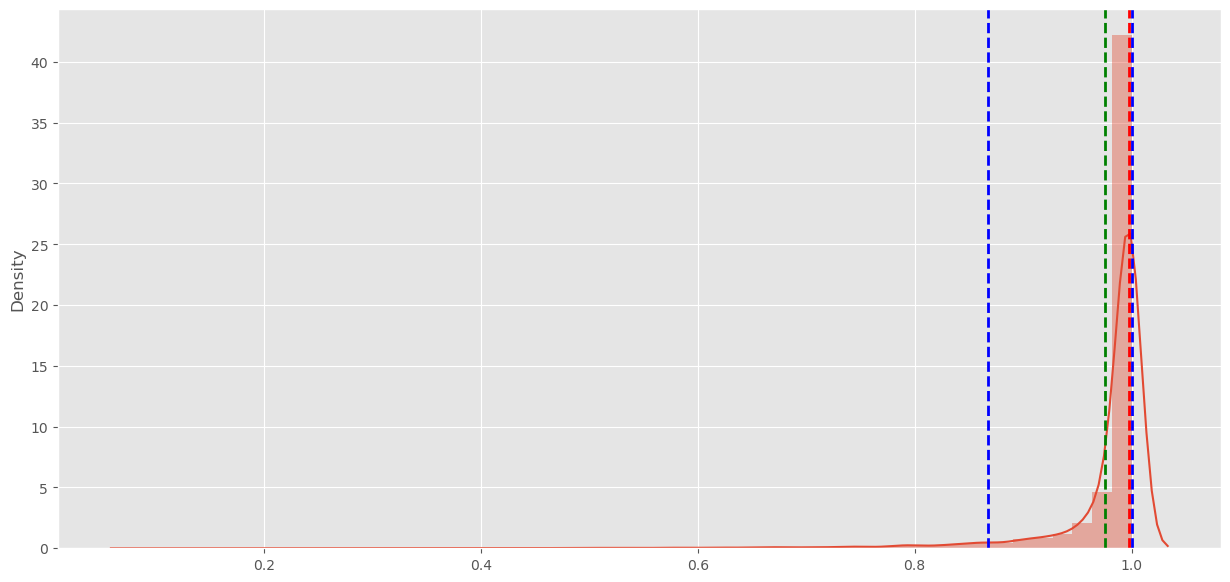

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,7))
sns.distplot(prob_31)
plt.axvline(np.quantile(prob_31, 0.95), color='b', linestyle="--", lw=2)
plt.axvline(np.quantile(prob_31, 0.05), color='b', linestyle="--", lw=2)
plt.axvline(np.mean(prob_31), color='g', linestyle="--", lw=2)
plt.axvline(np.median(prob_31), color='r', linestyle="--", lw=2)